# McDonald's Card Data Analysis - v5: Ingenico card tokens
## March 2018
### Dr Jose M Albornoz

This notebook generates plots of customer types as determined by the frequency of their visits; possible overlaps of the different categories have been accounted for. Customer duplication has been accounted for as well by using only card tokens generated by Ingenico.

# 1.- Import necessary modules, define SQLContext

In [1]:
# Import required modules
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import unix_timestamp

In [2]:
# Define SQLContext
sqlContext = SQLContext(sc)

# 2.- Generic function to load data from a csv file

In [3]:
def load_data(filename, schema, columns = None):
    df = sqlContext.read.format('com.databricks.spark.csv').option("delimiter", ";").options(header='false'). \
    load(filename, schema = schema)
    if columns is None:
        # If no columns are given, then select all
        columns = schema.names
    return df.select(columns)

# 3.- Data schema

In [4]:
schema = StructType([ 
    StructField('store_number', IntegerType(), True), 
    StructField('terminal_number', IntegerType(), True), 
    StructField('transaction_date', StringType(), True), 
    StructField('transaction_time', IntegerType(), True), 
    StructField('transaction_amount', IntegerType(), True),
    StructField('card_scheme', StringType(), True),
    StructField('pan_token', StringType(), True),
    StructField('empty_field', IntegerType(), True)    
])

# 4.- Load data

In [5]:
df_Sep2017I = sqlContext.read.csv("McD_Card_Data/Sep2017_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [6]:
df_Oct2017I  = sqlContext.read.csv("McD_Card_Data/Oct2017_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [7]:
df_Nov2017I = sqlContext.read.csv("McD_Card_Data/Nov2017_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [8]:
df_Dec2017I = sqlContext.read.csv("McD_Card_Data/Dec2017_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [9]:
df_Jan2018I = sqlContext.read.csv("McD_Card_Data/Jan2018_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [10]:
df_Feb2018I = sqlContext.read.csv("McD_Card_Data/Feb2018_I.csv", header=True, mode="DROPMALFORMED", schema=schema)

# 5.- Concatenate data

In [11]:
df_data0 = df_Sep2017I.unionAll(df_Oct2017I)

In [12]:
df_data0 = df_data0.unionAll(df_Nov2017I)

In [13]:
df_data0 = df_data0.unionAll(df_Dec2017I)

In [14]:
df_data0 = df_data0.unionAll(df_Jan2018I)

In [15]:
df_data0 = df_data0.unionAll(df_Feb2018I)

In [16]:
df_data0.count()

52311782

# 6.- Remove unnecessary data from memory

In [17]:
df_Sep2017I.unpersist()
df_Oct2017I.unpersist()
df_Nov2017I.unpersist()
df_Dec2017I.unpersist()
df_Jan2018I.unpersist()
df_Feb2018I.unpersist()

DataFrame[store_number: int, terminal_number: int, transaction_date: string, transaction_time: int, transaction_amount: int, card_scheme: string, pan_token: string, empty_field: int]

# 7.- Register data0 as table

In [18]:
df_data0.registerTempTable("data0")

# 8.- Compute count of unique cards

In [19]:
df_unique_cards = sqlContext.sql("SELECT DISTINCT pan_token FROM data0")

In [20]:
unique_cards = df_unique_cards.count()

In [21]:
unique_cards

18987584

# 9.- Order data0 by transaction date and card token

In [22]:
df_data0 = sqlContext.sql("SELECT * FROM data0 ORDER BY pan_token, transaction_date, transaction_time")

In [23]:
#df_data.show(40)

# 10.- Find frequency of visits per customer

## 10.1.- High-frequency customers: number of unique customers that have visited at least twice in any calendar week (H) 

In [24]:
df_weekly1 = df_data0.groupBy("pan_token", weekofyear(from_unixtime(unix_timestamp('transaction_date', 'yyy/MM/dd'))).\
                            alias('week')).agg(count("*").alias('visits')).sort('pan_token')
#df_weekly1.show(20)

In [25]:
df_weekly1.registerTempTable("weekly_visit1")

In [26]:
df_weekly2 = sqlContext.sql("SELECT DISTINCT pan_token \
                             FROM weekly_visit1 \
                             WHERE visits >= 2")

In [27]:
#df_weekly2.show(20)

In [28]:
H_count = df_weekly2.count()
H_count

4669845

### 10.1.1.- Register table with high-frequency customers (H) 

In [29]:
df_weekly2.registerTempTable('customersH')

### 10.1.2.- Remove high-frequency customers from data0 => data1 is generated

In [30]:
df_data1 = df_data0.join(df_weekly2, ["pan_token"], "leftanti")

In [31]:
df_data1.count()

23339454

In [32]:
df_data0.unpersist()
df_weekly1.unpersist()
df_weekly2.unpersist()

DataFrame[pan_token: string]

## 10.2.- Medium_frequency customers: number of unique customers that visit exactly twice in any calendar month (M)

In [33]:
df_monthly1 = df_data1.groupBy("pan_token", month(from_unixtime(unix_timestamp('transaction_date', 'yyy/MM/dd'))).\
                            alias('month')).agg(count("*").alias('visits')).sort('pan_token')
#df_monthly1.show(20)

In [34]:
df_monthly1.registerTempTable("monthly_visit1")

In [35]:
df_monthly2 = sqlContext.sql("SELECT DISTINCT pan_token\
                             FROM monthly_visit1 \
                             WHERE visits = 2")

In [36]:
M_count = df_monthly2.count()
M_count

2603001

### 10.2.1.- Register table with medium-frequency customers (H) 

In [37]:
df_monthly2.registerTempTable('customersM')

### 10.2.2.- Remove medium-frequency customers from data1 => data2 is generated

In [38]:
df_data2 = df_data1.join(df_monthly2, ["pan_token"], "leftanti")

In [39]:
df_data2.count()

15614576

In [40]:
df_data1.unpersist()
df_monthly1.unpersist()
df_monthly2.unpersist()

DataFrame[pan_token: string]

## 10.3.- Infrequent customers: number of unique customers that visit once in a 3 calendar month period (I)

In [41]:
interval = 90 * 24 * 60 * 60     # 3 months = 90 days  
gdf = df_data2.\
withColumn('quarter_interval', \
           from_unixtime(floor(unix_timestamp('transaction_date', 'yyy/MM/dd') / interval) * interval\
           + ((unix_timestamp(lit('2017/09/01'),'yyy/MM/dd')/interval)%1)*interval))

df_3month1 = gdf.groupBy('pan_token', 'quarter_interval').agg(count("*").alias('visits')).sort('pan_token')

In [42]:
df_3month1.registerTempTable("3month_visit1")

In [43]:
df_3month2 = sqlContext.sql("SELECT DISTINCT pan_token\
                             FROM 3month_visit1 \
                             WHERE visits = 1")

In [44]:
I_count = df_3month2.count()
I_count

10552691

### 10.3.1.- Register table with infrequent customers (I) 

In [45]:
df_3month2.registerTempTable('customersI')

### 10.3.2.- Remove infrequent customers from data2 => data3 is generated

In [46]:
df_data3 = df_data2.join(df_3month2, ["pan_token"], "leftanti")

In [47]:
df_data3.count()

2999490

In [48]:
df_data2.unpersist()
df_3month1.unpersist()
df_3month2.unpersist()

DataFrame[pan_token: string]

## 10.4.- Low-frequency customers: number of unique customers that visit once in any 6 calendar weeks lapse (L)

In [49]:
interval = 42 * 24 * 60 * 60     # 6 weeks = 42 days  
gdf = df_data3.\
withColumn('6week_interval', \
           from_unixtime(floor(unix_timestamp('transaction_date', 'yyy/MM/dd') / interval) * interval\
           + ((unix_timestamp(lit('2017/09/01'),'yyy/MM/dd')/interval)%1)*interval))

df_6weekly1 = gdf.groupBy('pan_token', '6week_interval').agg(count("*").alias('visits')).sort('pan_token')

#df_6weekly1.show(20)

In [50]:
df_6weekly1.registerTempTable("6weekly_visit1")

In [51]:
df_6weekly2 = sqlContext.sql("SELECT DISTINCT pan_token\
                             FROM 6weekly_visit1 \
                             WHERE visits = 1")

In [52]:
#df_6weekly2.show(40)

In [53]:
L_count = df_6weekly2.count()
L_count

437489

In [54]:
df_6weekly2.registerTempTable('customersL')

In [55]:
df_data3.unpersist()
gdf.unpersist()
df_6weekly1.unpersist()
df_6weekly2.unpersist()

DataFrame[pan_token: string]

## 10.5.- Rarely visiting customers: number of unique customers that less than once in a 3 calendar month period (R)

In [56]:
total = H_count + M_count + L_count + I_count

In [57]:
total

18263026

In [58]:
R_count = unique_cards - total

In [59]:
R_count

724558

# 11 Plots

In [60]:
H_count_pct = H_count*100/unique_cards

In [61]:
M_count_pct = M_count*100/unique_cards

In [62]:
L_count_pct = L_count*100/unique_cards

In [63]:
I_count_pct = I_count*100/unique_cards

In [64]:
R_count_pct = R_count*100/unique_cards

In [65]:
numcust = [H_count, M_count, L_count, I_count, R_count]

In [66]:
numcust_pct = [H_count_pct, M_count_pct, L_count_pct, I_count_pct, R_count_pct]

In [67]:
x = ['Twice a week or more', 'Twice a month', 'Once every 6 weeks', 'Once every 3 months', 'Rarely visits']

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

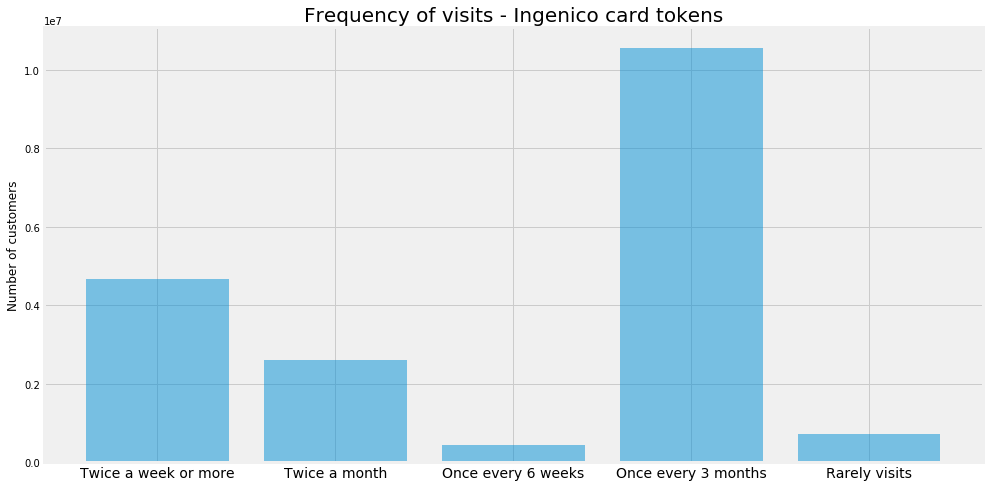

In [68]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
style.use('fivethirtyeight')
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(15, 8))

plt.bar(x, numcust, align='center', alpha=0.5)
plt.ylabel('Number of customers')
plt.title('Frequency of visits - Ingenico card tokens', fontsize=20)
plt.xticks(fontsize=14)

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

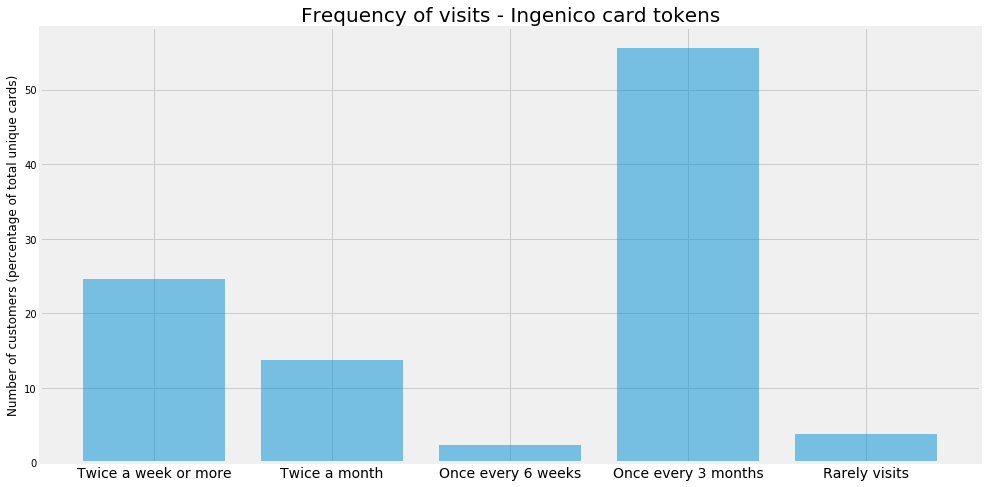

In [69]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
style.use('fivethirtyeight')
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(15, 8))

plt.bar(x, numcust_pct, align='center', alpha=0.5)
plt.ylabel('Number of customers (percentage of total unique cards)')
plt.title('Frequency of visits - Ingenico card tokens', fontsize=20)
plt.xticks(fontsize=14)

In [70]:
total = H_count + M_count + L_count + I_count

In [71]:
total

18263026

In [72]:
unique_cards - total

724558